In [1]:
# Install catalax
# !pip install catalax

In [2]:
import catalax as ctx
import catalax.neural as ctn
import warnings

warnings.filterwarnings("ignore")

# Neural ODE Training Example

This notebook demonstrates how to train a Neural ODE using the Catalax library. The example shows:

1. Creating a simple Michaelis-Menten model
2. Loading and augmenting a dataset 
3. Setting up a Neural ODE with RBF activation
4. Configuring a multi-step training strategy
5. Training the Neural ODE on the dataset

The Neural ODE learns to approximate the dynamics of the biochemical system from data.


In [3]:
# Create a model
model = ctx.Model(name="Michaelis-Menten")

# Add species
model.add_species(s1="Substrate")

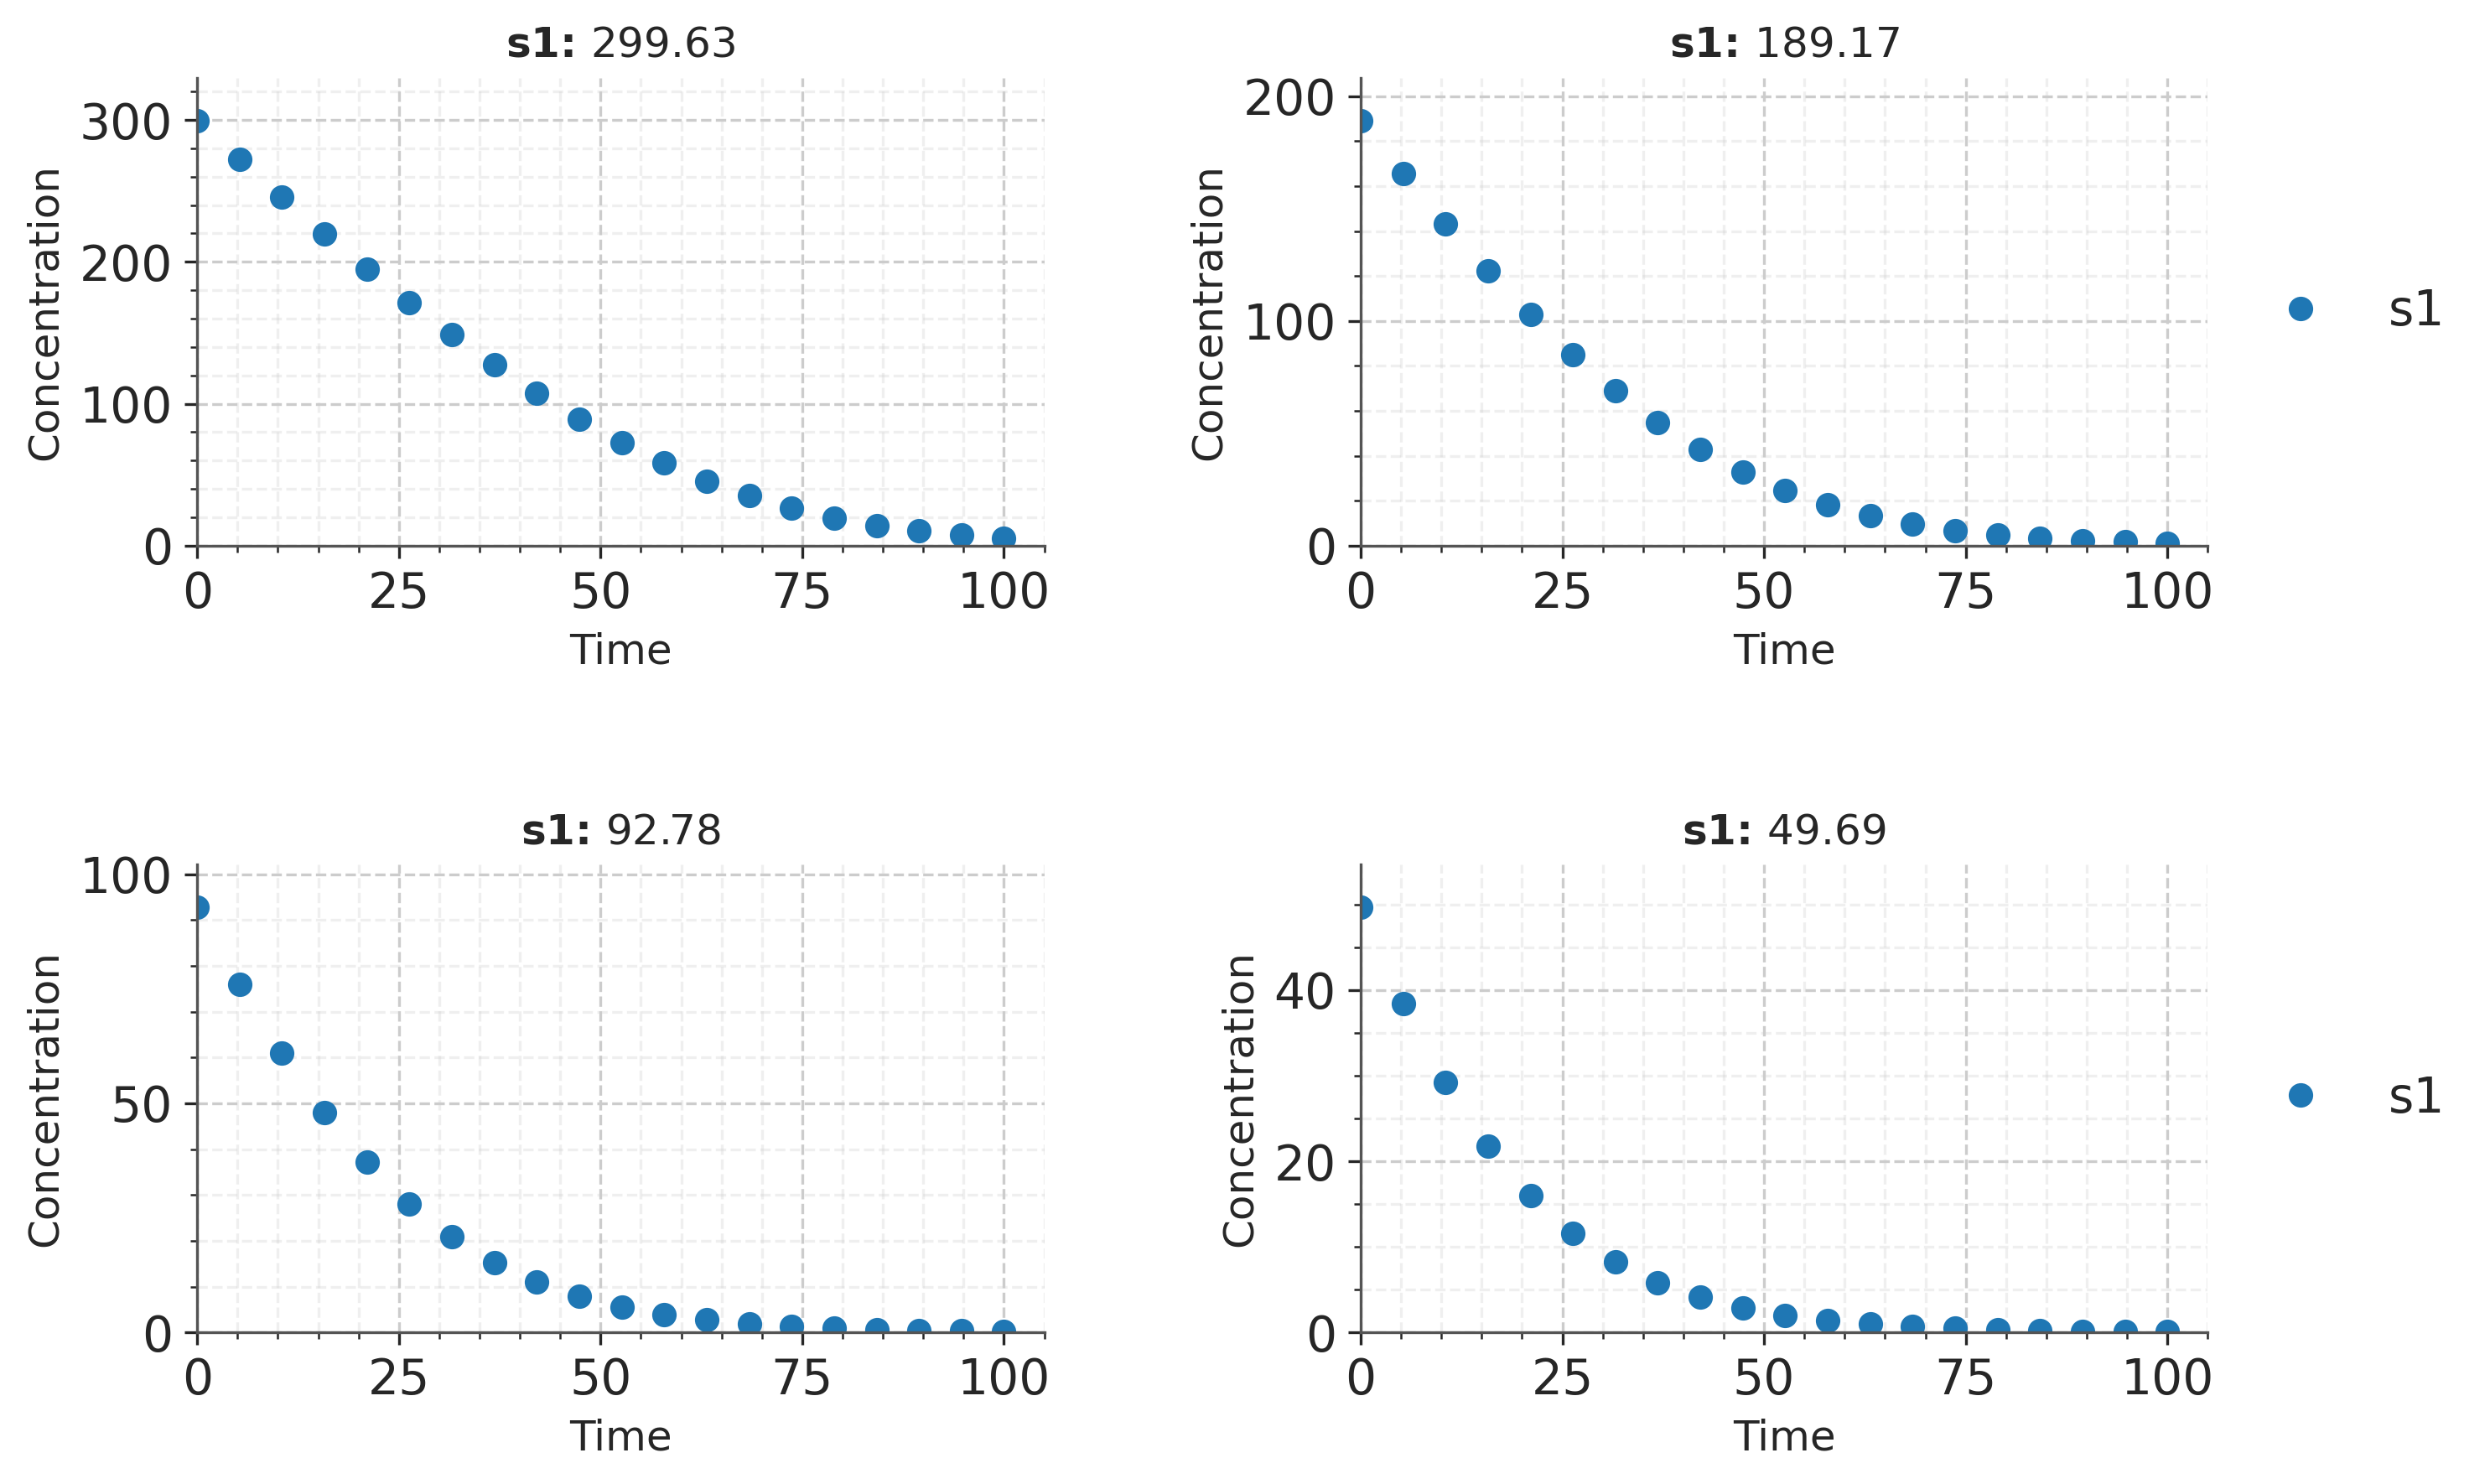

In [4]:
# Load the datasets
dataset = ctx.Dataset.from_croissant("datasets/croissant_dataset.zip")

# Augment the dataset
dataset = dataset.augment(n_augmentations=10, sigma=0.01)

f = dataset.plot(measurement_ids=[m.id for m in dataset.measurements[:4]])

In [5]:
# Create a neural ODE model
rbf = ctn.RBFLayer(0.6)
neural_ode = ctn.NeuralODE.from_model(
    model,
    width_size=16,
    depth=1,
    activation=rbf,
)

# Set up a training strategy (You can interchange the loss function too!)
strategy = ctn.Strategy()
strategy.add_step(lr=1e-3, length=0.1, steps=1000, batch_size=20, alpha=0.1)
strategy.add_step(lr=1e-3, steps=2000, batch_size=20, alpha=0.01)
strategy.add_step(lr=1e-4, steps=3000, batch_size=20, alpha=0.01)

# Train neural ODE
trained = ctn.train_neural_ode(
    model=neural_ode,
    dataset=dataset,
    strategy=strategy,
    print_every=10,
    weight_scale=1e-3,
    save_milestones=False,  # Set to True to save model checkpoints
    # log="progress.log", # Uncomment this line to log progress
)


TypeError: Strategy.add_step() got an unexpected keyword argument 'alpha'

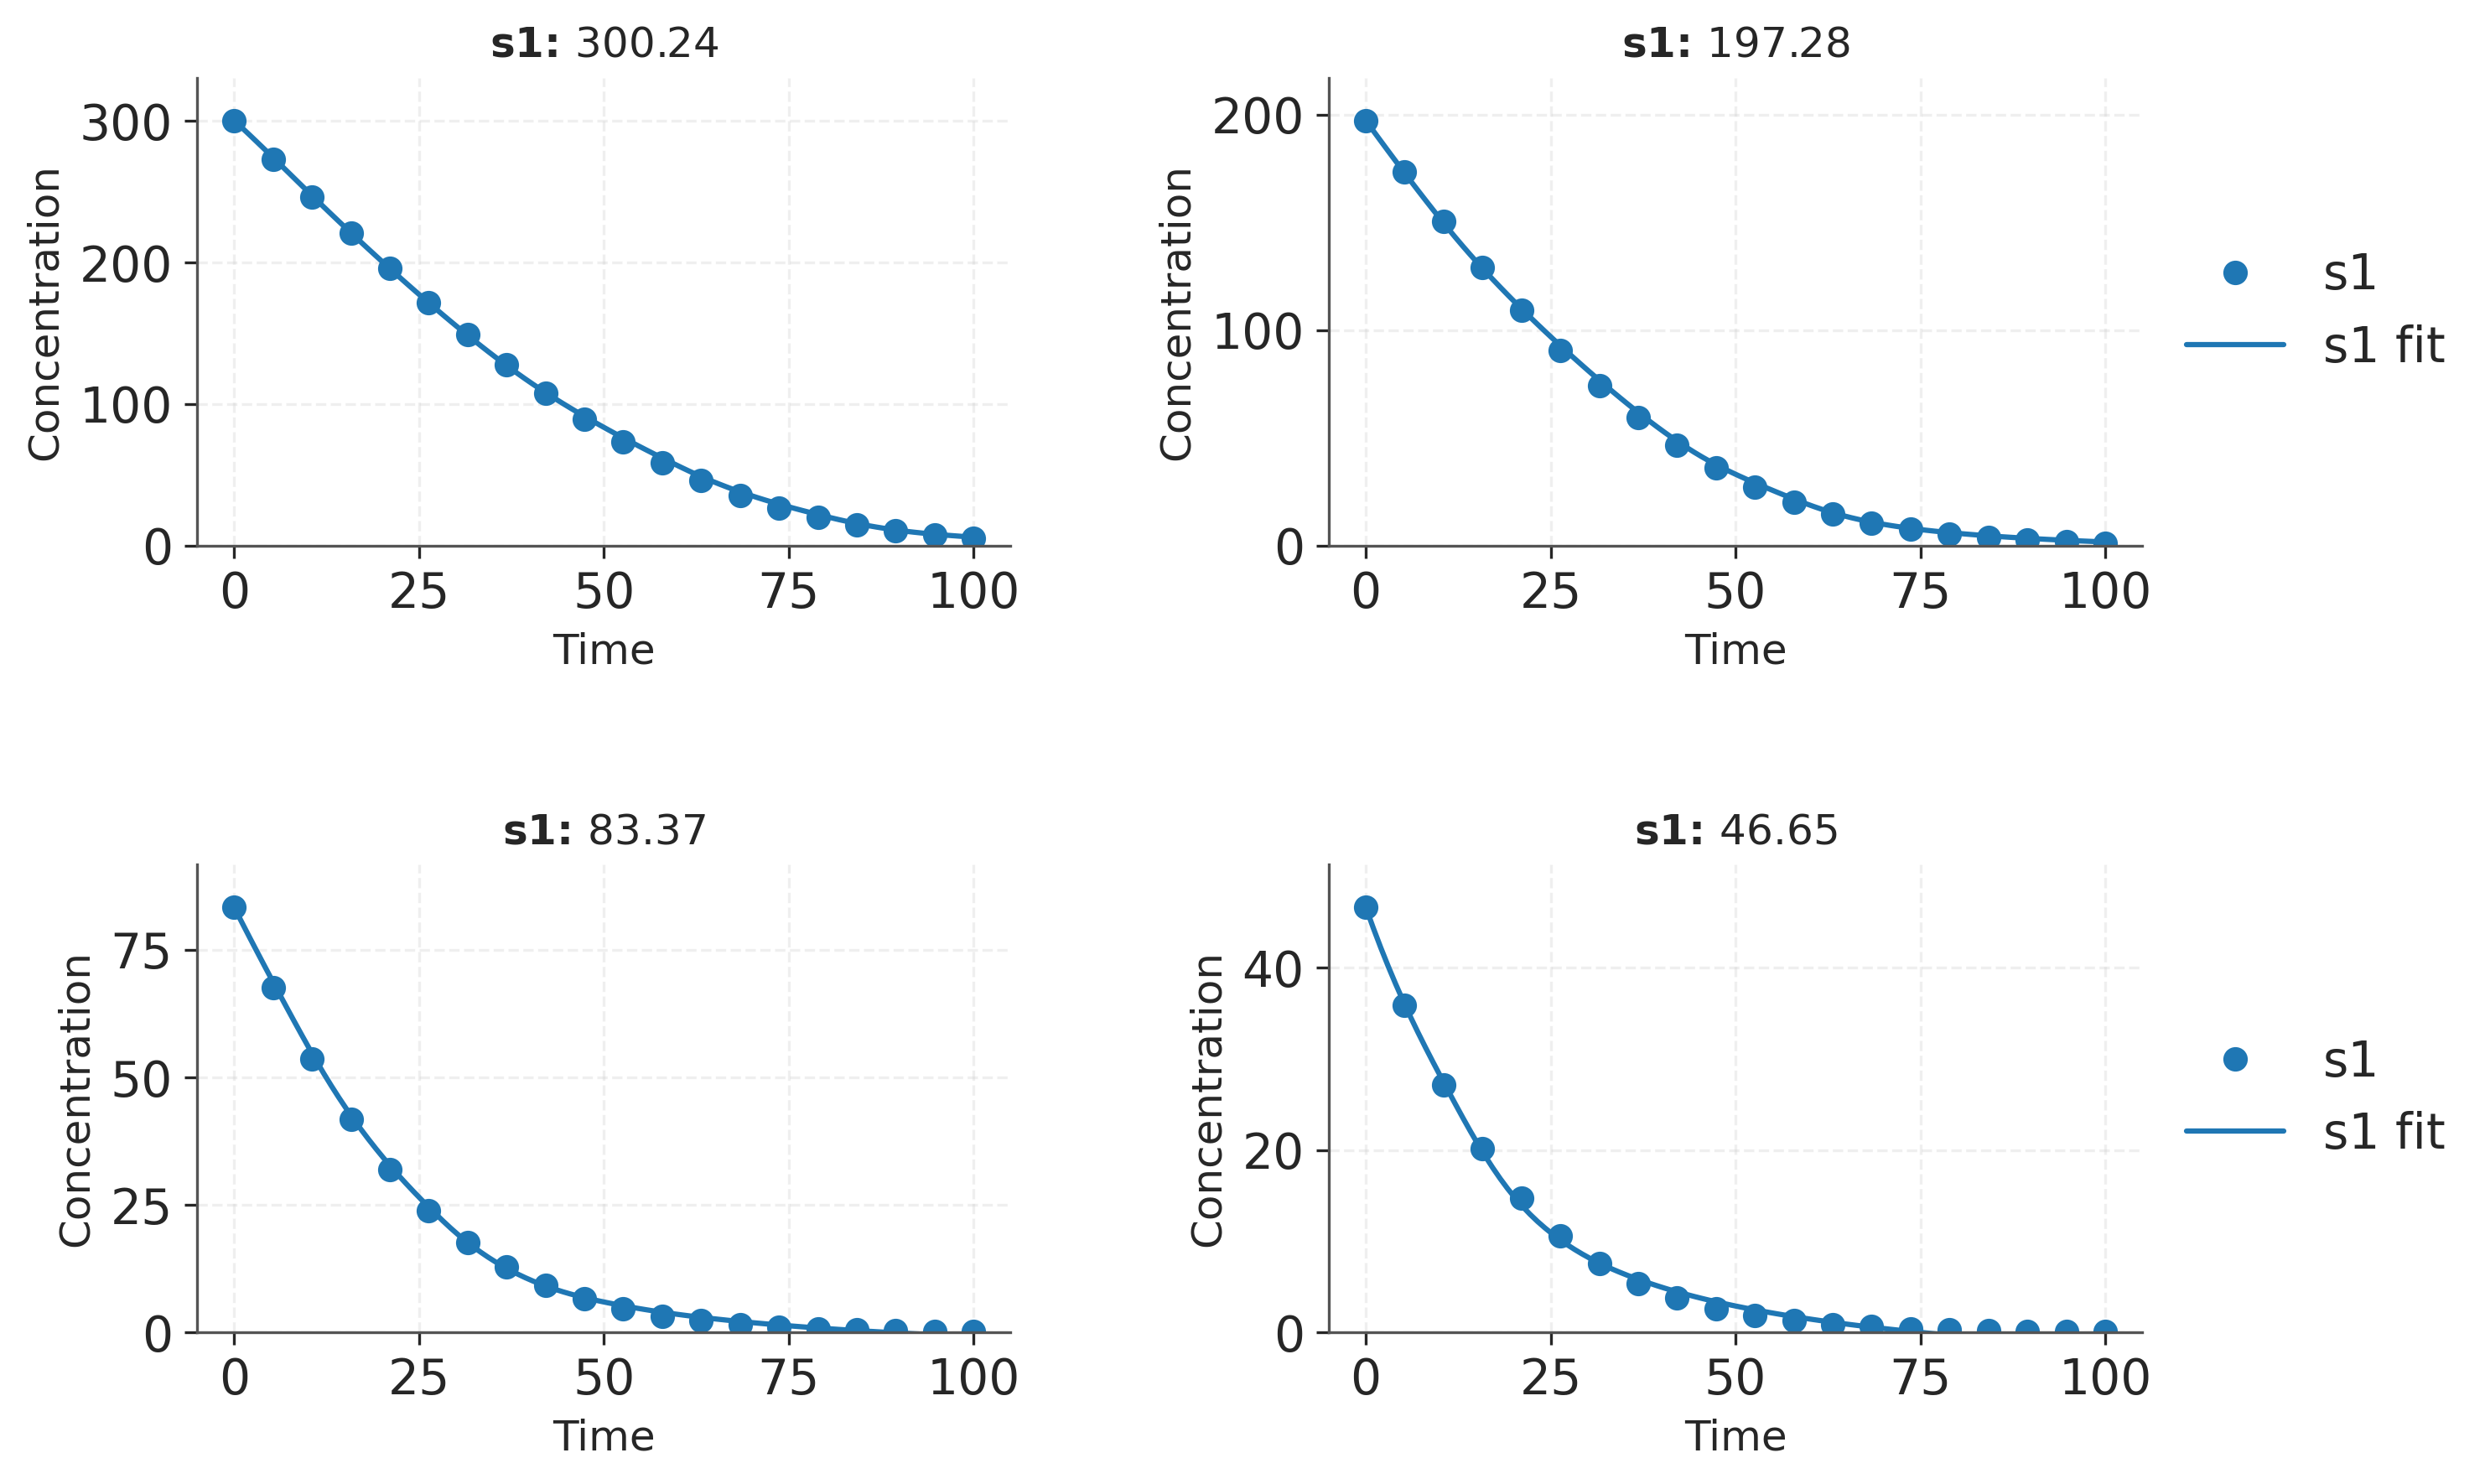

In [ ]:
# We can now visualize the fit of the neural ODE to the data
# Please note, a NeuralODE is a subclass of the Predictor class,
# which means it can be used as a predictor in the Dataset.plot method.
f = dataset.plot(
    predictor=trained,
    measurement_ids=[m.id for m in dataset.measurements[:4]],
    show=False,
)

In [ ]:
# Save model
trained.save_to_eqx("./trained/", "menten_trained")